# Create netcdfs to test CmCt
This notebook creates test data for running CmCt scripts.

### Setup

In [4]:
import rasterio
import numpy as np
import netCDF4 as nc
import os
from matplotlib import pyplot as plt

In [11]:
def tif2netcdf(fname):
    # Open the GeoTIFF file
    with rasterio.open(fname) as dataset:
        # Read the data as a numpy array
        data = dataset.read(1)  # Read the first band
    
        # Access metadata
        print("Number of bands:", dataset.count)
        print("CRS:", dataset.crs)
        print("Bounds:", dataset.bounds)
    
        height = data.shape[0]
        width = data.shape[1]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rasterio.transform.xy(dataset.transform, rows, cols)
        #print(xs, ys)
    
        # Print the data array
        print(data)

    # Create a new NetCDF file
    fname_nc = fname.split('.')[0] + '.nc'
    try:
        os.remove(fname_nc)
    except:
        pass
        
    dataset = nc.Dataset(fname_nc, 'w', format='NETCDF4')
    
    # Create dimensions
    x_dim = dataset.createDimension('x', width)
    y_dim = dataset.createDimension('y', height)
    time_dim = dataset.createDimension('time', 21)  # Unlimited dimension
    
    # Create variables
    x_ds = dataset.createVariable('x', np.float32, ('x',))
    y_ds = dataset.createVariable('y', np.float32, ('y',))
    time_ds = dataset.createVariable('time', np.float64, ('time',))
    lithk_ds = dataset.createVariable('lithk', np.float32, ('time', 'y', 'x'))
    
    # Write attributes
    time_ds.calendar = '360_day'
    time_ds.units = 'days since 2000-1-1 00:00:00'
    
    # Write data to variables
    x_ds[:] = np.array(xs)[0,:]
    y_ds[:] = np.array(ys)[:,0]
    time_ds[:] = np.arange(0, 360*21, 360)
    lithk_ds[:, :, :] = np.zeros( (21, height, width) )
    for i in range(1,21):
        lithk_ds[i, :, :] = data*i
    
    # Close the dataset
    dataset.close()
    
    return None


---

### AIS and GIS `lithk` netcdfs
The code below will write netcdfs for the `lithk` variable for both Antarctica and Greenland. These are produced from [Smith et al., 2020](https://doi.org/10.1126/science.aaz5845), which provides gridded rates of mass change for both ice sheets. The rates are used to calculate annual ice sheet thickness change through time over 2000-2020. Note that the output netcdfs start with zero ice sheet thickness in 2000. These output netcdfs can be used in the IMBIE and gravimetry comparison notebooks because those use ice sheet change over time in their comparisons against observations.

In [23]:
# NOTE that this will overwrite the netcdfs
tif2netcdf('ais_dmdt_grounded_filt.tif')
tif2netcdf('gris_dmdt_filt.tif')


Number of bands: 1
CRS: EPSG:3031
Bounds: BoundingBox(left=-2526157.069162289, bottom=-2129966.0144063435, right=2648842.930837711, top=2185033.9855936565)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Number of bands: 1
CRS: EPSG:3413
Bounds: BoundingBox(left=-626302.8769843741, bottom=-3241440.11183917, right=818697.1230156259, top=-676440.11183917)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


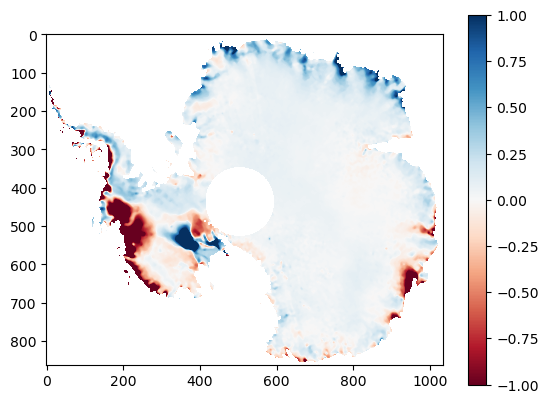

In [25]:
# As a check, read in the AIS netcdf and plot
dataset = nc.Dataset('ais_dmdt_grounded_filt.nc')
plt.imshow(dataset['lithk'][5,:,:], cmap='RdBu', vmin=-1, vmax=+1)
plt.colorbar()
dataset.close()


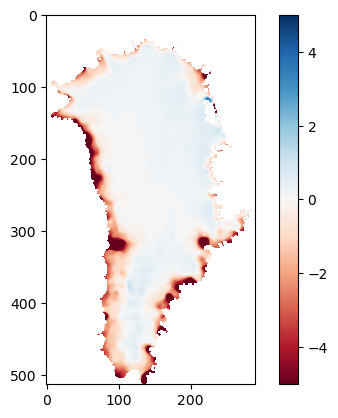

In [24]:
# As a check, read in the GIS netcdf and plot
dataset = nc.Dataset('gris_dmdt_filt.nc')
plt.imshow(dataset['lithk'][5,:,:], cmap='RdBu', vmin=-5, vmax=+5)
plt.colorbar()
dataset.close()
